In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import itertools

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D
from keras.optimizers import Adam, Adadelta
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [0]:
import scipy.io as sio
My_data = sio.loadmat('drive/Plant Classification Using C-CNN/train/Image_Processed_1data.mat')  
x_train = My_data['train']
labels = My_data["train_labels"]

In [0]:
#x_train, x_val, y_train, y_val = train_test_split(x_train, labels, test_size = 0.1, random_state=10, stratify=labels)
#print(len(x_train), len(x_val), len(y_train), len(y_val))

In [0]:
#x_train_dummy = x_train

x_train, x_val, y_train, y_val = train_test_split(x_train, labels, test_size = 0.1, random_state=10, stratify=labels)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.1, random_state=10, stratify =y_train)

In [0]:
#print('Train data:', len(x_train), ', Val data:', len(x_val), ', Test data:', len(x_test), ', Train labels:', len(y_train), ', Val labels:', len(y_val), ', Test labels:', len(y_test))

In [6]:
input_shape = x_train[1].shape
print('Input Shape is :', input_shape)

Input Shape is : (256, 256, 4)


In [7]:
from keras.layers import MaxPooling2D
from keras.layers import Add
from keras.layers import BatchNormalization

def Pyramidnet(x):
  #ResNet1, Number of filters =16
  x= Conv2D(16, (3,3), padding='same')(x)
  x= BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
  x= LeakyReLU(alpha=0.15)(x)
  x_in = Conv2D(16, (3,3), padding='same')(x)
  x_in = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x_in)
  x_in =LeakyReLU(alpha=0.15)(x_in)
  x_in = Conv2D(16, (3,3), padding='same')(x_in)
  x_out = Add()([x, x_in])
  x_out = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x_out)
  x_out = LeakyReLU(alpha=0.15)(x_out)
  #ResNet2, Number of filters =32
  x= Conv2D(32, (3,3), padding='same')(x_out)
  x= BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
  x= LeakyReLU(alpha=0.15)(x)
  x_in = Conv2D(32, (3,3), padding='same')(x)
  x_in = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x_in)
  x_in =LeakyReLU(alpha=0.15)(x_in)
  x_in = Conv2D(32, (3,3), padding='same')(x_in)
  x_out = Add()([x, x_in])
  x_out = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x_out)
  x_out = LeakyReLU(alpha=0.15)(x_out)
  #ResNet3, Number of filters =48
  x= Conv2D(48, (3,3), padding='same')(x_out)
  x= BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
  x= LeakyReLU(alpha=0.15)(x)
  x_in = Conv2D(48, (3,3), padding='same')(x)
  x_in = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x_in)
  x_in =LeakyReLU(alpha=0.15)(x_in)
  x_in = Conv2D(48, (3,3), padding='same')(x_in)
  x_out = Add()([x, x_in])
  x_out = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x_out)
  x_out = LeakyReLU(alpha=0.15)(x_out)
  
  return x_out



def fire_incept(x, fire=16, intercept=64):
  
  x = Conv2D(fire, (5,5), strides=(2,2))(x)
  x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
  x = LeakyReLU(alpha=0.15)(x)
    
  left = Conv2D(intercept, (3,3), padding='same')(x)
  left = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(left)
  left = LeakyReLU(alpha=0.15)(left)
    
  right = Conv2D(intercept, (5,5), padding='same')(x)
  right = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(right)
  right = LeakyReLU(alpha=0.15)(right)
    
  x = concatenate([left, right], axis=3)
  return x
  
  

def fire_squeeze(x, fire=16, intercept=64):
  
  x = Conv2D(fire, (1,1))(x)
  x= BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
  x = LeakyReLU(alpha=0.15)(x)
    
  left = Conv2D(intercept, (1,1))(x)
  left = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(left)
  left = LeakyReLU(alpha=0.15)(left)
    
  right = Conv2D(intercept, (3,3), padding='same')(x)
  right = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(right)
  right = LeakyReLU(alpha=0.15)(right)
    
  x = concatenate([left, right], axis=3)
  return x
    
  
image_input=Input(shape=input_shape)
ip = Pyramidnet(image_input)
ip = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(ip)
ip = Pyramidnet(ip)
ip = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(ip)
ip = Pyramidnet(ip)
ip = fire_incept(ip, fire=32, intercept=32)
ip = fire_squeeze(ip, fire=32, intercept=32)

ip = Conv2D(64, (3,3))(ip)
ip = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(ip)
ip = LeakyReLU(alpha=0.1)(ip)

ip = Flatten()(ip)

ip = Dense(512)(ip)
ip = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(ip)
ip = LeakyReLU(alpha=0.1)(ip)
ip = Dropout(0.5)(ip)

ip = Dense(256)(ip)
ip = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(ip)
ip = LeakyReLU(alpha=0.1)(ip)
ip = Dropout(0.2)(ip)


out = Dense(12, activation='softmax')(ip)

model_new = Model(image_input, out)
model_new.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 592         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 256, 256, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
model_new.compile(optimizer = Adam(lr=.00025) , loss = 'categorical_crossentropy', metrics=['accuracy'])

In [10]:
%%time

history = model_new.fit(x_train, y_train,validation_split=0.1, epochs=15, batch_size=25)

Train on 4498 samples, validate on 500 samples
Epoch 1/15
4498/4498 [==============================] - 453s 101ms/step - loss: 1.9677 - acc: 0.3735 - val_loss: 8.6525 - val_acc: 0.1680
Epoch 2/15
4498/4498 [==============================] - 437s 97ms/step - loss: 0.9617 - acc: 0.6963 - val_loss: 1.5616 - val_acc: 0.5860
Epoch 3/15
1425/4498 [========>.....................] - ETA: 4:48 - loss: 0.6436 - acc: 0.7916

4498/4498 [==============================] - 438s 97ms/step - loss: 0.6282 - acc: 0.7941 - val_loss: 0.7446 - val_acc: 0.7460
Epoch 4/15
4498/4498 [==============================] - 438s 97ms/step - loss: 0.4184 - acc: 0.8764 - val_loss: 0.8376 - val_acc: 0.7500
Epoch 5/15
3475/4498 [======================>.......] - ETA: 1:36 - loss: 0.3028 - acc: 0.9171

4498/4498 [==============================] - 438s 97ms/step - loss: 0.3106 - acc: 0.9102 - val_loss: 1.5319 - val_acc: 0.5840
Epoch 6/15
4498/4498 [==============================] - 438s 97ms/step - loss: 0.2173 - acc: 0.9400 - val_loss: 0.6650 - val_acc: 0.8060
Epoch 7/15
3950/4498 [=========================>....] - ETA: 51s - loss: 0.1465 - acc: 0.9694

4498/4498 [==============================] - 438s 97ms/step - loss: 0.1472 - acc: 0.9684 - val_loss: 0.7421 - val_acc: 0.7700
Epoch 8/15
4498/4498 [==============================] - 438s 97ms/step - loss: 0.1293 - acc: 0.9689 - val_loss: 0.5980 - val_acc: 0.8080
Epoch 9/15
4050/4498 [==========================>...] - ETA: 42s - loss: 0.0938 - acc: 0.9780

4498/4498 [==============================] - 438s 97ms/step - loss: 0.0953 - acc: 0.9780 - val_loss: 1.1858 - val_acc: 0.7180
Epoch 10/15
4498/4498 [==============================] - 438s 97ms/step - loss: 0.0859 - acc: 0.9824 - val_loss: 0.9006 - val_acc: 0.7260
Epoch 11/15
4050/4498 [==========================>...] - ETA: 42s - loss: 0.1051 - acc: 0.9736

4498/4498 [==============================] - 437s 97ms/step - loss: 0.1038 - acc: 0.9742 - val_loss: 1.1092 - val_acc: 0.6980
Epoch 12/15
4498/4498 [==============================] - 438s 97ms/step - loss: 0.0754 - acc: 0.9782 - val_loss: 0.6708 - val_acc: 0.8100
Epoch 13/15
4050/4498 [==========================>...] - ETA: 42s - loss: 0.0561 - acc: 0.9889

4498/4498 [==============================] - 438s 97ms/step - loss: 0.0568 - acc: 0.9887 - val_loss: 0.7629 - val_acc: 0.7580
Epoch 14/15
4498/4498 [==============================] - 438s 97ms/step - loss: 0.0546 - acc: 0.9882 - val_loss: 0.7748 - val_acc: 0.7920
Epoch 15/15
4050/4498 [==========================>...] - ETA: 42s - loss: 0.0609 - acc: 0.9867

4498/4498 [==============================] - 438s 97ms/step - loss: 0.0622 - acc: 0.9862 - val_loss: 0.6083 - val_acc: 0.8140
CPU times: user 1h 17min 35s, sys: 19min 8s, total: 1h 36min 44s
Wall time: 1h 49min 49s


In [0]:
y_val_pred = model_new.evaluate(x_val, y_val, batch_size=32, verbose=1, sample_weight=None)

print()
print ("Validation Loss = " + str(y_val_pred[0]))
print ("Validation Accuracy = " + str(y_val_pred[1]))

In [13]:
y_test_pred = model_new.evaluate(x_test, y_test, batch_size=32, verbose=1, sample_weight=None)

print()
print ("Test Loss = " + str(y_test_pred[0]))
print ("Test Accuracy = " + str(y_test_pred[1]))

556/556 [==============================] - 17s 30ms/step

Test Loss = 0.7274888316504389
Test Accuracy = 0.8075539568345323


In [14]:
y_train_pred = model_new.evaluate(x_train, y_train, batch_size=32, verbose=1, sample_weight=None)


4998/4998 [==============================] - 149s 30ms/step



In [15]:
print ("Train Loss = " + str(y_train_pred[0]))
print ("Train Accuracy = " + str(y_train_pred[1]))

Train Loss = 0.07382598635451752
Train Accuracy = 0.9787915166066427


In [16]:
y_train_pred =model_new.predict(x_train, batch_size=64, verbose=1, steps=None)
y_test_pred =model_new.predict(x_test, batch_size=64, verbose=1, steps=None)
y_val_pred =model_new.predict(x_val, batch_size=64, verbose=1, steps=None)

Saved model to disk


In [17]:

y_train_pred = np.argmax(y_train_pred, axis=1)
y_test_pred = np.argmax(y_test_pred, axis=1)
y_val_pred = np.argmax(y_val_pred, axis=1)

4998/4998 [==============================] - 151s 30ms/step


In [0]:
y_train_x = np.argmax(y_train, axis=1)
y_test_x = np.argmax(y_test, axis=1)
y_val_x = np.argmax(y_val, axis=1)

In [0]:
#y_val_pred = np.argmax(y_val_pred, axis=1)
#y_val = np.argmax(y_val, axis=1)


Classification Matrix
[[250   0   0   0   0   0   1   0   0   0   0   0]
 [  0 363   0   2   0   0   0   0   0   0   1   0]
 [  0   0 271   0   0   0   0   0   0   0   0   0]
 [  1   0   0 577   0   0   0   0   0   0   0   0]
 [  0   0   0   0 205   0   0   0   0   0   0   0]
 [  0   1   0   3   0 432   0   0   0   0   0   0]
 [  3   0   0   0   0   0 617   0   0   0   0   0]
 [  0   0   0  16   0   0   0 192   0   0   0   0]
 [  0   0   0  21   0   0   0   0 471   0   0   0]
 [  0   0   0  19   0   0   0   0   0 203   0   0]
 [  0   0   0  12   1   0   0   0   0   0 461   0]
 [  0   0   0   0   0   0   0   0   1   0   0 374]]
Confusion matrix
[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.99 0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.01 0.   0.99 0

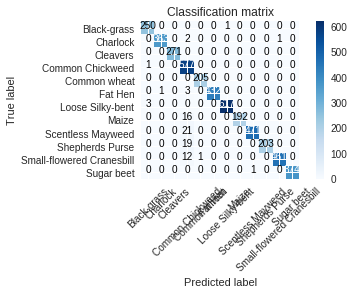

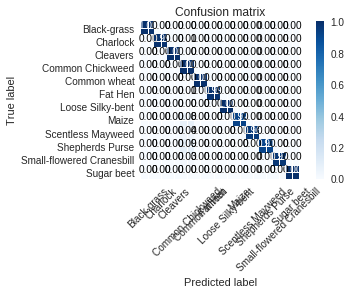

In [0]:
from sklearn.metrics import confusion_matrix
SPECIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen',
              'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse',
              'Small-flowered Cranesbill', 'Sugar beet']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion matrix")
    else:
        print('Classification Matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix for Train
cnf_matrix = confusion_matrix(y_train_x, y_train_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=SPECIES,
                      title='Classification matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=SPECIES, normalize=True,
                      title='Confusion matrix')



plt.show()





Classification Matrix
[[13  0  0  0  1  0 12  0  2  0  0  0]
 [ 0 35  0  0  0  0  1  0  1  1  2  1]
 [ 0  2 28  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 64  0  0  0  0  0  0  0  0]
 [ 1  0  0  0 21  0  1  0  0  0  0  0]
 [ 0  0  0  1  1 40  2  0  1  1  0  2]
 [10  0  0  0  2  0 54  0  2  0  1  0]
 [ 0  0  0  6  0  0  0 12  3  0  1  1]
 [ 1  1  0  3  0  0  0  0 48  0  0  1]
 [ 0  0  0 12  1  0  0  0  0 12  0  0]
 [ 0  1  0  6  0  0  0  0  1  0 45  0]
 [ 2  0  0  1  1  0  0  0  2  1  1 34]]
Confusion matrix
[[0.46 0.   0.   0.   0.04 0.   0.43 0.   0.07 0.   0.   0.  ]
 [0.   0.85 0.   0.   0.   0.   0.02 0.   0.02 0.02 0.05 0.02]
 [0.   0.07 0.93 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.04 0.   0.   0.   0.91 0.   0.04 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.02 0.02 0.83 0.04 0.   0.02 0.02 0.   0.04]
 [0.14 0.   0.   0.   0.03 0.   0.78 0.   0.03 0.   0.01 0.  ]
 [0.   0.   0.   0.26 0.   0.   0.   0.52 0.13 0.  

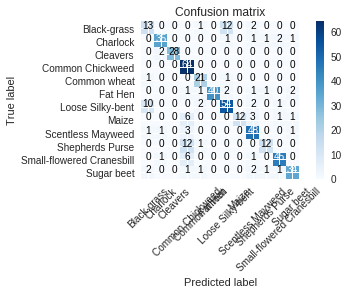

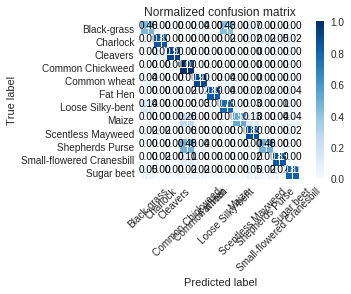

In [0]:

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_x, y_test_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=SPECIES,
                      title='Confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=SPECIES, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Classification Matrix
[[13  0  0  0  1  0 16  0  1  0  0  0]
 [ 0 42  0  1  0  0  0  0  2  0  0  0]
 [ 0  2 27  3  1  0  0  0  0  0  0  1]
 [ 0  0  0 69  1  0  0  0  0  0  0  1]
 [ 0  0  1  0 23  1  0  0  0  0  0  0]
 [ 2  0  3  2  1 40  0  0  4  1  0  1]
 [ 9  0  0  4  1  0 63  0  0  0  0  0]
 [ 0  0  0  8  0  0  0 15  1  0  0  2]
 [ 0  1  0  5  0  1  1  0 50  0  0  3]
 [ 0  1  0 11  0  0  0  0  5 10  0  0]
 [ 0  1  0  9  0  0  0  0  1  1 46  1]
 [ 0  0  1  3  1  1  0  0  2  0  2 36]]
Confusion matrix
[[0.42 0.   0.   0.   0.03 0.   0.52 0.   0.03 0.   0.   0.  ]
 [0.   0.93 0.   0.02 0.   0.   0.   0.   0.04 0.   0.   0.  ]
 [0.   0.06 0.79 0.09 0.03 0.   0.   0.   0.   0.   0.   0.03]
 [0.   0.   0.   0.97 0.01 0.   0.   0.   0.   0.   0.   0.01]
 [0.   0.   0.04 0.   0.92 0.04 0.   0.   0.   0.   0.   0.  ]
 [0.04 0.   0.06 0.04 0.02 0.74 0.   0.   0.07 0.02 0.   0.02]
 [0.12 0.   0.   0.05 0.01 0.   0.82 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.31 0.   0.   0.   0.58 0.04 0.  

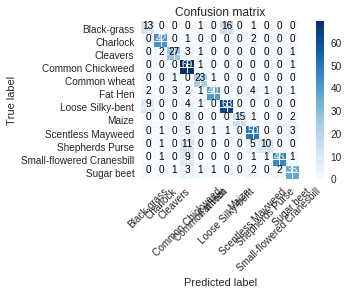

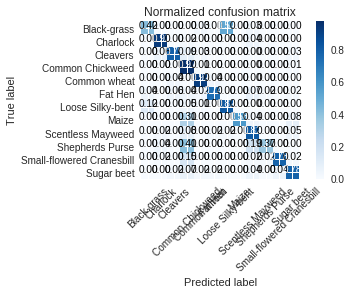

In [0]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val_x, y_val_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=SPECIES,
                      title='Confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=SPECIES, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [0]:

print(history.history.keys())


dict_keys(['loss', 'acc'])


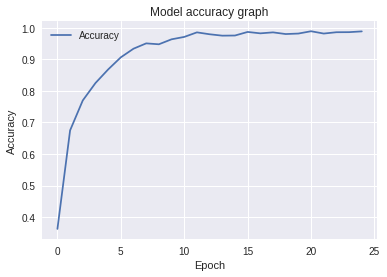

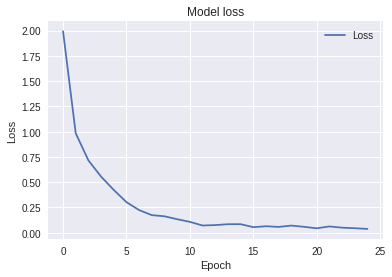

In [0]:
from matplotlib import axes as plt2
from matplotlib import pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.plot(history.history['loss'])
plt.title('Model accuracy graph')
plt.ylabel('Accuracy')

plt.xlabel('Epoch')
plt.legend(['Accuracy'], loc='upper centre')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()